In [2]:
import sys
sys.path.insert(0,'python')
from fastRWpkl import *
from scipy import signal
import numpy as np
import scipy
from scipy import signal
from scipy.ndimage.morphology import binary_dilation as bd
import scipy.ndimage as ndimage
from functools import partial
import multiprocessing
import numpy.ma as ma
from collections import Counter

In [8]:
def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus/(xgaus.sum()), ygaus/(ygaus.sum()))
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2.: center[0]+xwin/2., center[1]-ywin/2.:center[1]+ywin/2.]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

In [3]:
data = parallel_rw_pkl(None, 'inter_sent%i'%2, 'r')
mask = parallel_rw_pkl(None, 'inter_sentm%i'%2, 'r')
modis_sent = ma.array(data, mask=mask)

b4 = parallel_rw_pkl(None, 'band4', 'r')
stm = parallel_rw_pkl(None, 'std_m', 'r')
p_mask = np.unique(stm)

Sent = b4
struct = ndimage.generate_binary_structure(2, 2)

In [9]:
def get_pixels(i):
    sent =  np.zeros_like(Sent)
    mask = (stm==i)  
    brdf = (Counter(modis_sent[mask]).most_common(1)[0][0])*0.001
    xmin = np.where(mask)[0].min()
    xmax = np.where(mask)[0].max()
    ymin = np.where(mask)[1].min()
    ymax = np.where(mask)[1].max()
    indx = np.where(mask)[0]
    indy = np.where(mask)[1]
    dia_mask = bd(mask, structure=struct, iterations=200)
    sent[dia_mask] = Sent[dia_mask]
    to_conv = sent[min(np.where(dia_mask)[0]):max(np.where(dia_mask)[0])+1,
                   min(np.where(dia_mask)[1]):max(np.where(dia_mask)[1])+1]
    mask = mask[xmin:xmax+1, ymin:ymax+1]
    
    return np.array([mask,np.array(to_conv), np.array(brdf), indx, indy], dtype = object)

#Gaussian one
def shift(pat, mode='gaus'): 
    mask,to_conv, brdf, indx, indy = pat
    print mask.sum()
    if (mask.sum() >= 2000) and (mask.sum() < 3000):
        
        if mode == 'mean':
            w = 1./(np.nansum(mask))
            k = np.zeros(mask.shape).astype('float')
            k[mask] = w
            conved = signal.fftconvolve(to_conv, k, mode='valid')
            dif = abs(conved-u)
            minm = np.nanmin(dif)
            x = np.where(dif == minm)[0][0]-np.ceil((conved.shape[0])/2.)
            y = np.where(dif == minm)[1][0]-np.ceil((conved.shape[1])/2.)
            vals = conved[np.where(dif == minm)[0][0], np.where(dif == minm)[1][0]]
            return [x, y , brdf, vals, indx,indy]

        elif mode == 'gaus':
            
            inds = pkl.load(open('pkls/gaus_trans.pkl','rb'))
            #vx,vy = pkl.load(open('pkls/gaus_valid.pkl','rb'))
            
            xwin, ywin = 100, 100  
            cost = []
            start = 1.
            star = 1
            end = 60
            for xstd in np.arange(8,20,1):
                for ystd in np.arange(10,30,1):
                    if xstd <=ystd:
                        for angle in xrange(30,160, 2):
                            
                            gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                            
                            kernel = np.zeros((99, 225))
                            kernel[inds[1], inds[0]] = gaus.ravel()
                            
                            if kernel.sum() <= 0:
                                return 0
                            else:
                                ker = kernel/(kernel.sum())
                                conved = signal.fftconvolve(to_conv, ker, mode='valid')
                                dif = abs(conved-brdf)
                                minm = np.nanmin(dif)
                                if minm<start:
                                    x = np.where(dif == minm)[0][0]-np.ceil((conved.shape[0])/2.)
                                    y = np.where(dif == minm)[1][0]-np.ceil((conved.shape[1])/2.)
                                    vals = conved[np.where(dif == minm)[0][0], np.where(dif == minm)[1][0]]
                                    cost.append([xstd, ystd, angle, x, y , brdf, vals, indx, indy])
                                    start = minm
                                    print 'Find One!!', start
                    else:
                        pass
            return cost[-1]           
        else:
            pass   
    else:
        pass
        

In [4]:
ites = np.array_split(p_mask, 5)[2]
ite = np.array_split(ites, len(ites)/40)

In [ ]:
patches = (get_pixels(k) for k in ite[0])
par = partial(shift, mode='gaus')
pool = multiprocessing.Pool(processes=45)
data = pool.map(par, patches)
pool.close()
pool.join()
parallel_rw_pkl(data, '0107testgaus', 'w')

In [16]:
xstd = []
ystd = []
angle = []
sx = []
sy = []
brdf = []
vals = []
indx = []
indy = []

for i in data:
    for j,k in enumerate([xstd, ystd, angle, sx, sy , brdf, vals, indx, indy]):
        try:
            k.append(i[j])
        except:
            pass

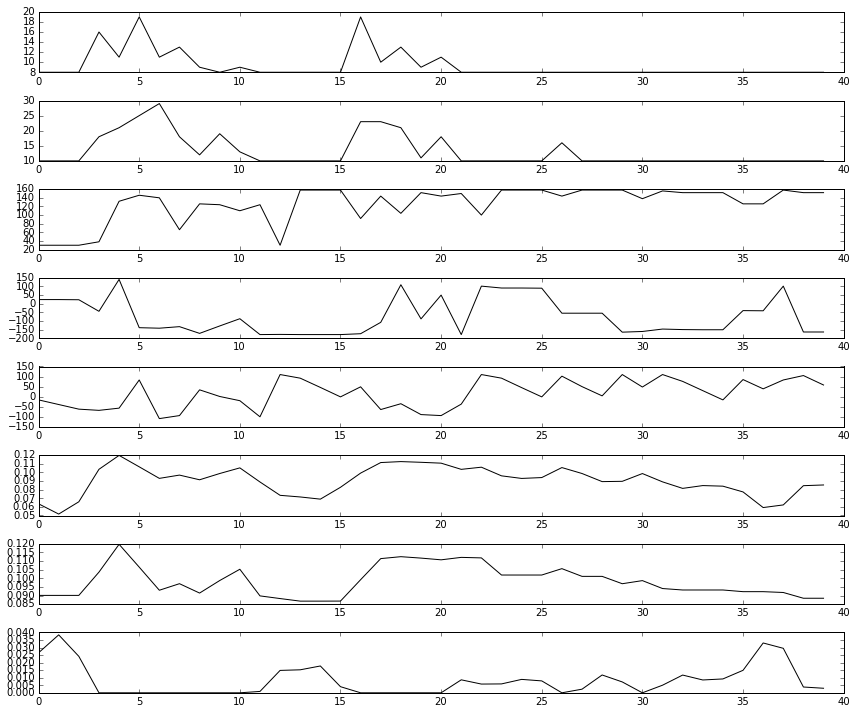

In [19]:
%matplotlib inline 
import pylab as plt
fig = plt.figure(figsize = (12,10))
for k,l in enumerate([xstd, ystd, angle, sx, sy , brdf, vals,abs(brdf-np.array(vals))]):
    pind = int('81%s'%(k+1))
    ax = fig.add_subplot(pind)
    ax.plot(l, color='k')
    ax.set_xlim(0, len(l))
    #fig.colorbar(im)
plt.tight_layout()

LinregressResult(slope=1.000000135066168, intercept=-1.4869649012094754e-08, rvalue=0.99999999999997413, pvalue=9.1218338199758888e-68, stderr=7.1928024387722888e-08)


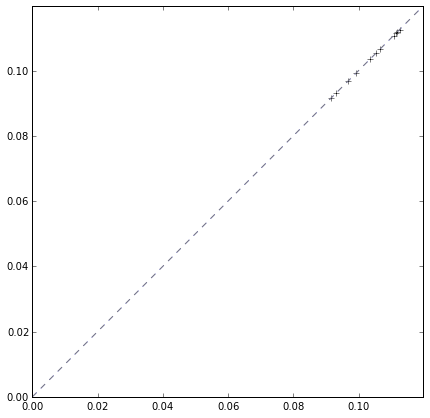

In [22]:
a = np.array(brdf)[np.array(xstd)>8]
b = np.array(vals)[np.array(xstd)>8]
op_cost = np.array(zip(a, b))
plt.figure(figsize = (7,7))
maxval = np.nanmax(op_cost)
r = scipy.stats.linregress(op_cost[:,1],op_cost[:,0])

fit = np.polyfit(op_cost[:,1],op_cost[:,0],1)
fit_fn = np.poly1d(fit)
#plt.figure(figsize = (7,7))
plt.plot(op_cost[:,1],op_cost[:,0], 'k+')
plt.plot([0,1],[0.,1], '--',linewidth=0.5)
plt.plot(np.arange(0,1,0.1), fit_fn(np.arange(0,1,0.1)), '--', color='grey')
plt.xlim(0, maxval)
plt.ylim(0, maxval)
print r

In [26]:
means = []
optimal1 = np.array(xstd)>8
inds = pkl.load(open('pkls/gaus_trans.pkl','rb'))

for k,l in enumerate([xstd, ystd, angle, sx, sy]):
    data = np.array(l)
    means.append((data[optimal1]).mean())
xwin, ywin = 100, 100
xst,yst,angl, xs, ys = means

test = Sent.copy()
gaus = gaussian(xwin,ywin,xst,yst,angl,False)                            
kernel = np.zeros((99, 225))
kernel[inds[1], inds[0]] = gaus.ravel()

ker = kernel/(kernel.sum())

conveds = []


for i,j in enumerate(indx):
    to_conv = np.zeros_like(ker)
    to_conv[inds[1], inds[0]] = 
    conved = signal.fftconvolve(to_conv, ker, mode='valid')
    if list(conved) == []:
        conveds.append(0)
        
    else:
        conveds.append((conved)[0][0])

/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


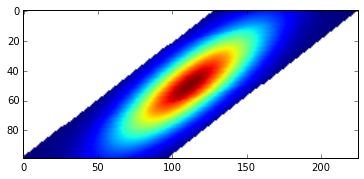

In [33]:
kernel = np.zeros((99, 225))
kernel[:] = np.nan
kernel[inds[1], inds[0]] = gaus.ravel()
plt.imshow(kernel)

In [39]:
def get_pixels(i):
    sent =  np.zeros_like(Sent)
    mask = (stm==i)  
    brdf = (Counter(modis_sent[mask]).most_common(1)[0][0])*0.001
    xmin = np.where(mask)[0].min()
    xmax = np.where(mask)[0].max()
    ymin = np.where(mask)[1].min()
    ymax = np.where(mask)[1].max()
    indx = np.where(mask)[0]
    indy = np.where(mask)[1]
    dia_mask = bd(mask, structure=struct, iterations=200)
    sent[dia_mask] = Sent[dia_mask]
    to_conv = sent[min(np.where(dia_mask)[0]):max(np.where(dia_mask)[0])+1,
                   min(np.where(dia_mask)[1]):max(np.where(dia_mask)[1])+1]
    mask = mask[xmin:xmax+1, ymin:ymax+1]
    
    return np.array([mask,np.array(to_conv), np.array(brdf), indx, indy], dtype = object)


In [ ]:
sent =  np.zeros_like(Sent)
mask = (stm==100)  
brdf = (Counter(modis_sent[mask]).most_common(1)[0][0])*0.001
xmin = np.where(mask)[0].min()
xmax = np.where(mask)[0].max()
ymin = np.where(mask)[1].min()
ymax = np.where(mask)[1].max()

center0 = np.array([(xmax-xmin)/2, (ymax-ymin)/2])

center1 = np.array(49, 112)

offset = center0 - center1

kernel = np.zeros((99, 225))
kernel[inds[1], inds[0]] = gaus.ravel()

indx = np.where(mask)[0]
indy = np.where(mask)[1]
dia_mask = bd(mask, structure=struct, iterations=200)
sent[dia_mask] = Sent[dia_mask]
to_conv = sent[min(np.where(dia_mask)[0]):max(np.where(dia_mask)[0])+1,
               min(np.where(dia_mask)[1]):max(np.where(dia_mask)[1])+1]
mask = mask[xmin:xmax+1, ymin:ymax+1]

return np.array([mask,np.array(to_conv), np.array(brdf), indx, indy], dtype = object)

In [41]:
center0 = np.array([(xmax-xmin)/2, (ymax-ymin)/2])

center1 = np.array([49, 112])
offset = center0 - center1
if offset <0:
    pass
else:
    inds[1] = inds[1] + offset[0]
    inds[0] = inds[0] + offset[1]

In [42]:
offset

array([-22, -89])